In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
import numpy as np

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
n_images = 3_000
img_size = 64

x   = np.linspace(-4,4,img_size)
X,Y = np.meshgrid(x,x)


# initialize tensors containing images and labels
images = torch.zeros(n_images,1,img_size,img_size)

for i in range(n_images):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  width = np.random.rand()/.6 + 1.8 # random width
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*width**2) )
  
  # and add noise
  G  = G + np.random.randn(img_size,img_size)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,img_size,img_size)

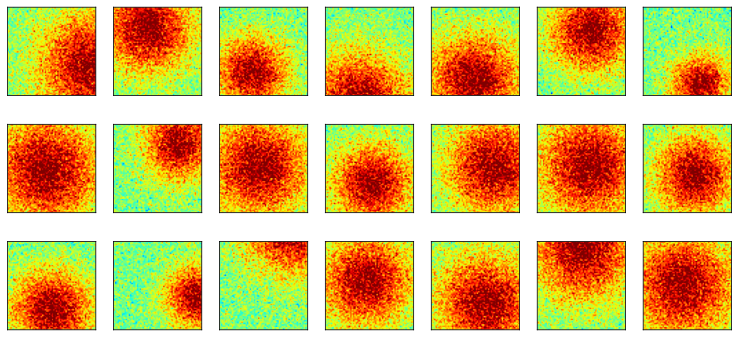

In [4]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(n_images)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [5]:
class DiscriminatorNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1, bias=False) # (img_size + 2  - 4)/2 + 1 = 32
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False) # (32 + 2 - 4)/2 + 1 = 16
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False) # (16 + 2 - 4)/2 + 1 = 8
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False) # (8 + 2 - 4)/2 + 1 = 4
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0, bias=False) # (4+0-4) + 1 = 1

    def forward(self, x):
        x = nn.functional.leaky_relu(self.conv1(x), .2)
        x = nn.functional.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        x = nn.functional.leaky_relu(self.conv3(x), .2)
        x = self.bn3(x)
        x = nn.functional.leaky_relu(self.conv4(x), .2)
        x = self.bn4(x)
        return torch.sigmoid(self.conv5(x)).reshape(-1, 1)
    
dnet = DiscriminatorNet()
dnet.to(device=device)
summary(dnet, (1, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,024
            Conv2d-2          [-1, 128, 16, 16]         131,072
       BatchNorm2d-3          [-1, 128, 16, 16]             256
            Conv2d-4            [-1, 256, 8, 8]         524,288
       BatchNorm2d-5            [-1, 256, 8, 8]             512
            Conv2d-6            [-1, 512, 4, 4]       2,097,152
       BatchNorm2d-7            [-1, 512, 4, 4]           1,024
            Conv2d-8              [-1, 1, 1, 1]           8,192
Total params: 2,763,520
Trainable params: 2,763,520
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.38
Params size (MB): 10.54
Estimated Total Size (MB): 11.93
----------------------------------------------------------------


In [6]:
whichpic

1047

In [7]:
images[whichpic].unsqueeze(0).shape

torch.Size([1, 1, 64, 64])

In [8]:
x = torch.randn(10, 1, 64, 64, device=device)
y = dnet(x)
x.shape, y.shape

(torch.Size([10, 1, 64, 64]), torch.Size([10, 1]))

In [9]:
class GeneratorNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Hout​=(Hin​−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
        self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False) # (1-1)*1 - 2*0 + 3 + 0 + 1 = 4
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False) # (4-1)*2 - 2*1 + 3 + 0 + 1 = 8
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False) # (8-1)*2 - 2*1 + 3 + 0 + 1 = 16
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False) # (16-1)*2 - 2*1 + 3 + 0 + 1 = 32
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False) # (32-1)*2 - 2*1 + 3 + 0 + 1 = 64
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.bn4(self.conv4(x)))
        return torch.tanh(self.conv5(x))
    
gnet = GeneratorNet()
gnet.to(device=device)
summary(gnet, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
   ConvTranspose2d-3            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-4            [-1, 256, 8, 8]             512
   ConvTranspose2d-5          [-1, 128, 16, 16]         524,288
       BatchNorm2d-6          [-1, 128, 16, 16]             256
   ConvTranspose2d-7           [-1, 64, 32, 32]         131,072
       BatchNorm2d-8           [-1, 64, 32, 32]             128
   ConvTranspose2d-9            [-1, 1, 64, 64]           1,024
Total params: 3,574,656
Trainable params: 3,574,656
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.91
Params size (MB): 13.64
Estimated Total Size (MB): 15.54
-------------------------------------

In [10]:
x = torch.randn(10, 100, 1, 1, device=device)
y = gnet(x)
y.shape

torch.Size([10, 1, 64, 64])

In [11]:
images.device

device(type='cpu')

In [12]:
epochs = 1_500
lossfunc = nn.BCELoss()
dnet = DiscriminatorNet()
dnet.to(device=device)
gnet = GeneratorNet()
gnet.to(device=device)
batch_size = 86
losses = np.zeros((epochs, 2))
disc_desc = np.zeros((epochs, 2))
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5, .999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5, .999))

for ei in range(epochs):
    batch_idxs = np.random.randint(0,images.shape[0],batch_size)

    # Train the descriminator
    x_real = images[batch_idxs,:,:,:]
    x_real = x_real.to(device=device)
    y_real = torch.ones(batch_size, 1, device=device)
    y_real_pred = dnet(x_real)
    d_loss_real = lossfunc(y_real_pred, y_real)
    x_fake = gnet(torch.randn(batch_size, 100, 1, 1, device=device))
    y_fake = torch.zeros(batch_size, 1, device=device)
    y_fake_pred = dnet(x_fake)
    d_loss_fake = lossfunc(y_fake_pred, y_fake)
    d_loss = d_loss_real + d_loss_fake
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    losses[ei, 0] = d_loss.cpu().item()
    disc_desc[ei, 0] = torch.mean((y_real_pred>.5).float()).cpu().item()
    # Train the Generator
    x_real = gnet(torch.randn(batch_size, 100, 1, 1, device=device))
    y_real = torch.ones(batch_size, 1, device=device)
    y_real_pred = dnet(x_real)
    g_loss = lossfunc(y_real_pred, y_real)
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
    losses[ei, 1] = g_loss.cpu().item()
    disc_desc[ei, 1] = torch.mean((y_real_pred>.5).float()).cpu().item()
    if (ei+1)%100==0:
        print(f"Epoch: {ei}, d_loss: {d_loss.cpu().item():.2f}, g_loss: {g_loss.cpu().item():.2f}, desc desc: {disc_desc[ei, 1]:.2f}")

Epoch: 99, d_loss: 0.00, g_loss: 26.06, desc desc: 0.00
Epoch: 199, d_loss: 0.89, g_loss: 1.84, desc desc: 0.02
Epoch: 299, d_loss: 0.80, g_loss: 1.41, desc desc: 0.09
Epoch: 399, d_loss: 1.76, g_loss: 0.43, desc desc: 0.86
Epoch: 499, d_loss: 0.90, g_loss: 1.00, desc desc: 0.26
Epoch: 599, d_loss: 1.17, g_loss: 1.18, desc desc: 0.05
Epoch: 699, d_loss: 1.44, g_loss: 0.36, desc desc: 0.98
Epoch: 799, d_loss: 1.46, g_loss: 1.13, desc desc: 0.17
Epoch: 899, d_loss: 1.20, g_loss: 1.92, desc desc: 0.03
Epoch: 999, d_loss: 1.02, g_loss: 1.92, desc desc: 0.01
Epoch: 1099, d_loss: 0.95, g_loss: 1.98, desc desc: 0.00
Epoch: 1199, d_loss: 0.93, g_loss: 0.91, desc desc: 0.23
Epoch: 1299, d_loss: 0.84, g_loss: 1.81, desc desc: 0.00
Epoch: 1399, d_loss: 1.65, g_loss: 2.50, desc desc: 0.00
Epoch: 1499, d_loss: 1.32, g_loss: 1.75, desc desc: 0.01


In [13]:
def smooth(x, k=15):
    return np.convolve(x, np.ones(k)/k, mode="same")

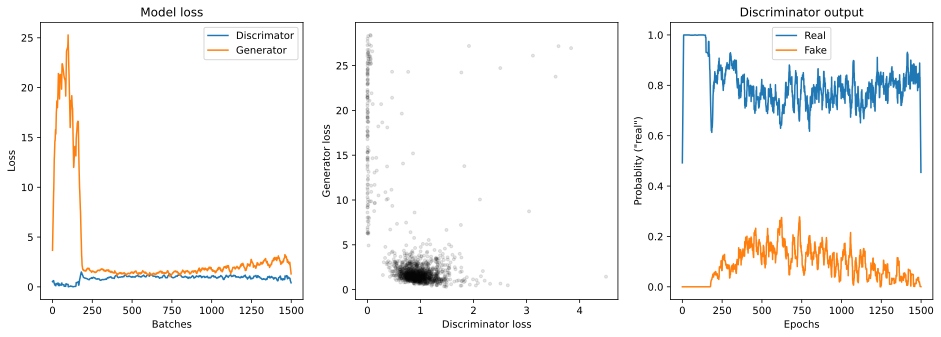

In [14]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,900])

ax[1].plot(losses[:,0],losses[:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disc_desc[:,0]))
ax[2].plot(smooth(disc_desc[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

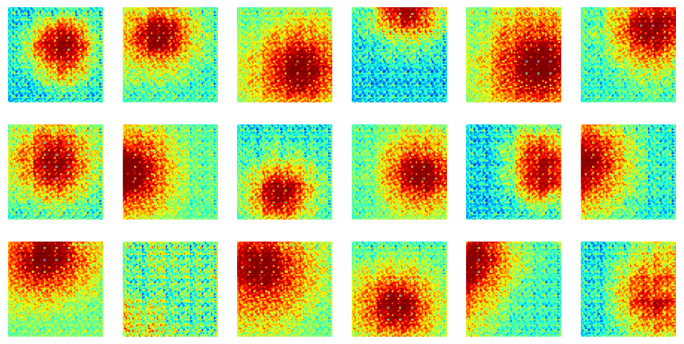

In [15]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batch_size,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
  ax.axis('off')

plt.show()